In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 40*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-01 16:17:22.418999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 16:17:22.651030: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-01 16:17:23.348753: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [3]:
sim_names = ["Koch_Meinhardt_1", "Koch_Meinhardt_2", "Koch_Meinhardt_3",
             "Koch_Meinhardt_4", "Koch_Meinhardt_5",
             "Koch_Meinhardt_6", "Koch_Meinhardt_7", "Koch_Meinhardt_9"]
sim_name = sim_names[1]
x_slice=slice(0,99,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,99,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-300,
               data_time_len=60,
               data_time_step=5)

In [4]:
class NN_Field(tu.NN_base):
    def __init__(self, x_range, y_range, depth, dim_2d, layer_num, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(dtype, **kwargs)
        self.depth = depth
        self.layer_num = layer_num
        self.dim_2d = dim_2d
        x = tf.constant(x_range, dtype=dtype)
        y = tf.constant(y_range, dtype=dtype)
        #Y,X = tf.meshgrid(x, y, indexing='ij')
        #X, Y = tf.meshgrid(x, y)
        Y, X = tf.meshgrid(x, y)
        self.X = X
        self.Y = Y
        self.domain_shape = X.shape
        self.build()
        
    def make_variables(self, k, initializer):
        return tf.Variable(initializer(shape=k, dtype=self.dtype))
    
                           
    def build(self):
        """Create the state of the layers (weights)"""
        weights = []
        scales = []
        biases = []
        
        rnd_init = tf.random_normal_initializer(stddev=1/6)
        W = tf.Variable(self.make_variables([self.depth, 3], rnd_init)
                        , dtype=self.dtype)
        #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        a = tf.Variable(tf.ones([1, 1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        b = tf.Variable(tf.zeros([1, 1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        
        weights.append(W)
        scales.append(a)
        biases.append(b)
        for i in range(self.layer_num-1):
            rnd_init = tf.random_normal_initializer(stddev=1/(2*self.depth))
            W = tf.Variable(self.make_variables([self.depth, self.depth], rnd_init)
                        , dtype=self.dtype)
            #b = tf.Variable(tf.zeros([128, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
            a = tf.Variable(tf.ones([1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
            b = tf.Variable(tf.zeros([1, 1, self.depth], dtype=self.dtype), dtype=self.dtype)
        
            weights.append(W)
            scales.append(a)
            biases.append(b)
            
        rnd_init = tf.random_normal_initializer(stddev=1/4)
        W = tf.Variable(self.make_variables([2, self.depth], rnd_init)
                        , dtype=self.dtype)
        #b = tf.Variable(tf.zeros([2, self.dim_2d[0], self.dim_2d[1]], dtype=self.dtype), dtype=self.dtype)
        a = tf.Variable(tf.ones([1, 1, 2], dtype=self.dtype), dtype=self.dtype)
        b = tf.Variable(tf.zeros([1, 1, 2], dtype=self.dtype), dtype=self.dtype)
        
        weights.append(W)
        scales.append(a)
        biases.append(b)

        self.Ws = weights
        self.scales = scales
        self.bs = biases

    def make_inputs(self, ts):
        T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(self.X.shape)[:, :, tf.newaxis]       
        return T
        
    @tf.function
    def net(self, T):
        #T = tf.fill(self.domain_shape, t)
#         H = tf.concat([tf.expand_dims(self.X, 0), 
#                        tf.expand_dims(self.Y, 0), 
#                        tf.expand_dims(T, 0)], axis=0)
    

    
         
        
        #T = ts[tf.newaxis, tf.newaxis, :] * tf.ones(self.X.shape)[:, :, tf.newaxis]
        #print(T)
        # H will be a tensor (batches, m, n, 3)
        # where batches is the len of ts,
        #       m,n are the width and hieght of the domain
        #       and 3 is for x,y,t
        H = tf.concat([tf.concat([self.X[tf.newaxis, :, :, tf.newaxis], 
                                 self.Y[tf.newaxis, :, :, tf.newaxis],
                                 T[:, :, i:i+1][tf.newaxis, :, :, :]], axis=3) for i in range(T.shape[-1])], axis=0)
        #print(H)
        def act(x):
            return x*tf.sigmoid(x)
        
        for W, a, b in zip(self.Ws, self.scales, self.bs):
            #print(W)
            mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])
            #print(mul_outputs)
            outputs =  a * mul_outputs + b
            #outputs =  mul_outputs + b
            #print(outputs)
            #H = tf.tanh(outputs)
            #H = tf.sigmoid(outputs)
            H = act(outputs)
            #print(H)

        return outputs
    
    @tf.function
    def net2(self, t):                
        T = tf.fill(self.domain_shape, t)
        
        H = tf.concat([tf.expand_dims(self.X, 0), 
                       tf.expand_dims(self.Y, 0), 
                       tf.expand_dims(T, 0)], axis=0)
        
        for W, a, b in zip(self.Ws, self.scales, self.bs):
            mul_outputs = tf.tensordot(W, H, axes=[[0], [0]])
            #print(mul_outputs)
            outputs =  a * mul_outputs + b
            #print(outputs)
            H = tf.tanh(outputs)
            #print(H)

        return outputs

    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.

        Return:   The returns 'partial_1' and 'partial_2' are the first and second
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]

        """
        partials_1 = [tf.gradients(outputs[:, i], inputs)[0] for i in range(outputs.shape[1])]
        partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
        return partials_1, partials_2



In [5]:

# x = tf.constant(np.arange(x_slice.start, x_slice.stop)*pattern.simulation.L[0]/pattern.simulation.n[0], 
#                 dtype=tf.float32)
# y = tf.constant(np.arange(y_slice.start, y_slice.stop)*pattern.simulation.L[1]/pattern.simulation.n[0], 
#                 dtype=tf.float32)
x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]
optimizer=keras.optimizers.Adam(learning_rate=2e-4)
pinn = NN_Field(x_range, y_range, 
                depth=32, 
                dim_2d=(pattern.block_x, pattern.block_x), 
                layer_num = 6,
                dtype=tf.float32)
norm_l2 = L2()
#x = tf.constant(x_range[x_slice], dtype=tf.float32)
#y = tf.constant(y_range[y_slice], dtype=tf.float32)
#x = 2.0 * (x - tf.reduce_min(x)) / (tf.reduce_max(x) - tf.reduce_min(x)) - 1.0
#y = 2.0 * (y - tf.reduce_min(y)) / (tf.reduce_max(y) - tf.reduce_min(y)) - 1.0
#X,Y = tf.meshgrid(x, y)

D_u = pattern.params["D_u"]
D_v = pattern.params["D_u"]
sigma_u = pattern.params["sigma_u"]
sigma_v = pattern.params["sigma_v"]
mu_u = pattern.params["mu_u"]
rho_u = pattern.params["rho_u"]
rho_v = pattern.params["rho_v"]
kappa_u = pattern.params["kappa_u"]
#@tf.function
def grads(pinn, ts):
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(pinn.X)
        tape.watch(pinn.Y)        
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)
            T = pinn.make_inputs(ts)
            tape2.watch(T)     
            
            outputs = pinn.net(T)
        
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
        u_x = tape2.gradient(u, pinn.X)
        u_y = tape2.gradient(u, pinn.Y)
        u_t = tape2.gradient(u, T)
        v_x = tape2.gradient(v, pinn.X)
        v_y = tape2.gradient(v, pinn.Y)
        v_t = tape2.gradient(v, T)
            
    u_xx = tape.gradient(u_x, pinn.X)
    u_xy = tape.gradient(u_x, pinn.Y)
    u_yx = tape.gradient(u_y, pinn.X)
    u_yy = tape.gradient(u_y, pinn.Y)
    v_xx = tape.gradient(v_x, pinn.X)
    v_yy = tape.gradient(v_y, pinn.Y)
    v_xy = tape.gradient(v_x, pinn.Y)
    v_yx = tape.gradient(v_y, pinn.X)
    #return (u, u_xx, u_yy, u_t, v, v_xx, v_yy, v_t)
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_xy), tf.squeeze(u_yx), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_xy), tf.squeeze(v_yx), tf.squeeze(v_t))
        
        
@tf.function
def train_step(elements):
    #t = elements[0][0]
    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(pinn.X)
        tape.watch(pinn.Y)
        #tape.watch(t)
        trainables = pinn.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn.X)
            tape2.watch(pinn.Y)
            T = pinn.make_inputs(elements[0])
            #tape2.watch(T)
            
            outputs = pinn.net(T)            
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
            u_x = tape2.gradient(u, pinn.X)
            u_y = tape2.gradient(u, pinn.Y)
            #u_t = tape2.gradient(u, T)
            #u_t = tf.einsum("ijt -> tij", u_t)
            
            v_x = tape2.gradient(v, pinn.X)
            v_y = tape2.gradient(v, pinn.Y)
            #v_t = tape2.gradient(v, T)
            #v_t = tf.einsum("ijt -> tij", v_t)
            
        
        u_xx = tape.gradient(u_x, pinn.X)
        #u_xy = tape.gradient(u_x, pinn.Y)
        #u_yx = tape.gradient(u_y, pinn.X)
        u_yy = tape.gradient(u_y, pinn.Y)
        v_xx = tape.gradient(v_x, pinn.X)
        v_yy = tape.gradient(v_y, pinn.Y)
        #v_xy = tape.gradient(v_x, pinn.Y)
        #v_yx = tape.gradient(v_y, pinn.X)
        #print(u_xx)
        #partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
               
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u# - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v# - v_t
        
        #print(u.shape)
        #print(u_xx.shape)
        #u_xyyx_diff = u_xy - u_yx
        #v_xyyx_diff = v_xy - v_yx

        #diff = outputs - elements[1] 
        #print(elements[1].shape)
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)


        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        #l2_res_u_xyyx = tf.reduce_sum(u_xyyx_diff**2)
        #l2_res_v_xyyx = tf.reduce_sum(v_xyyx_diff**2)
        
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v #+ l2_res_u_xyyx + l2_res_v_xyyx
        
        
    grads = tape.gradient(l2, trainables)
    optimizer.apply_gradients(zip(grads, trainables))
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)#, l2_res_u_xyyx, l2_res_v_xyyx)




In [6]:
def gen_series():    
    for i,t in enumerate(pattern.t_star):
        yield t, pattern.c[..., i]
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((), pattern.c.shape[:-1]))

In [7]:
pattern.t_star.shape

(12,)

In [11]:
#optimizer.lr.assign(1e-5)
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n")
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
losses = tu.train(epochs=10000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0


2023-02-01 16:19:08.197956: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f4298018e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-01 16:19:08.197997: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2023-02-01 16:19:08.205054: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-01 16:19:08.733422: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


at epoch 0
 total loss: 268467.65625 u: 258545.03125, v: 246.78256225585938,
 Res u: 9577.83203125, Res v: 98.010009765625 

Time taken: 13.41s

Start of epoch 100
at epoch 100
 total loss: 16153.560546875 u: 15805.45703125, v: 3.4791555404663086,
 Res u: 344.5146484375, Res v: 0.10919758677482605 

Time taken: 33.47s

Start of epoch 200
at epoch 200
 total loss: 15670.7548828125 u: 15180.625, v: 3.2406764030456543,
 Res u: 486.88250732421875, Res v: 0.006965781562030315 

Time taken: 33.27s

Start of epoch 300
at epoch 300
 total loss: 15226.9970703125 u: 14917.826171875, v: 2.635702610015869,
 Res u: 306.50921630859375, Res v: 0.025970347225666046 

Time taken: 33.01s

Start of epoch 400
at epoch 400
 total loss: 14991.1796875 u: 14816.341796875, v: 2.30013370513916,
 Res u: 172.5037841796875, Res v: 0.03460105508565903 

Time taken: 32.47s

Start of epoch 500
at epoch 500
 total loss: 14895.33984375 u: 14774.1943359375, v: 2.1879587173461914,
 Res u: 118.91638946533203, Res v: 0.042


Start of epoch 4600
at epoch 4600
 total loss: 4652.88818359375 u: 4474.044921875, v: 0.6471952795982361,
 Res u: 169.2139892578125, Res v: 8.98242473602295 

Time taken: 36.97s

Start of epoch 4700
at epoch 4700
 total loss: 4413.62548828125 u: 4223.37451171875, v: 0.5786608457565308,
 Res u: 180.3024444580078, Res v: 9.370351791381836 

Time taken: 36.91s

Start of epoch 4800
at epoch 4800
 total loss: 4049.67919921875 u: 3883.939697265625, v: 0.4952841103076935,
 Res u: 156.07000732421875, Res v: 9.174074172973633 

Time taken: 36.75s

Start of epoch 4900
at epoch 4900
 total loss: 3931.936767578125 u: 3738.87890625, v: 0.5024327039718628,
 Res u: 183.18655395507812, Res v: 9.36888599395752 

Time taken: 37.61s

Start of epoch 5000
at epoch 5000
 total loss: 3627.96142578125 u: 3464.127685546875, v: 0.4555399417877197,
 Res u: 154.95169067382812, Res v: 8.42651653289795 

Time taken: 37.25s

Start of epoch 5100
at epoch 5100
 total loss: 3383.644287109375 u: 3223.7587890625, v: 0.4


Start of epoch 9100
at epoch 9100
 total loss: 651.4732666015625 u: 594.7415771484375, v: 0.13346244394779205,
 Res u: 45.114418029785156, Res v: 11.483736991882324 

Time taken: 37.24s

Start of epoch 9200
at epoch 9200
 total loss: 562.8472290039062 u: 517.4461669921875, v: 0.10724468529224396,
 Res u: 33.93975067138672, Res v: 11.3540678024292 

Time taken: 37.62s

Start of epoch 9300
at epoch 9300
 total loss: 596.1737670898438 u: 537.6241455078125, v: 0.12673726677894592,
 Res u: 46.586055755615234, Res v: 11.836833953857422 

Time taken: 37.56s

Start of epoch 9400
at epoch 9400
 total loss: 494.9076232910156 u: 448.3384094238281, v: 0.1172245666384697,
 Res u: 34.861915588378906, Res v: 11.590097427368164 

Time taken: 37.16s

Start of epoch 9500
at epoch 9500
 total loss: 484.7218933105469 u: 440.3220520019531, v: 0.10112819075584412,
 Res u: 32.49901580810547, Res v: 11.799680709838867 

Time taken: 37.09s

Start of epoch 9600
at epoch 9600
 total loss: 530.0261840820312 u: 4

In [803]:
np.array(losses_2).shape

(60012, 4)

In [12]:
def sum_per(arr, element_nums_by=2):
    return np.sum(arr.reshape(-1, element_nums_by), axis=1)

losses2 = np.array(losses)
element_nums_by = 12#len(losses)//2
losses2 =np.concatenate([sum_per(losses2[:, 0], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 1], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 2], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 3], element_nums_by)[:, np.newaxis],
                        # sum_per(losses2[:, 4], element_nums_by)[:, np.newaxis],
                        # sum_per(losses2[:, 5], element_nums_by)[:, np.newaxis]
                        ], axis=1)

#losses2.shape

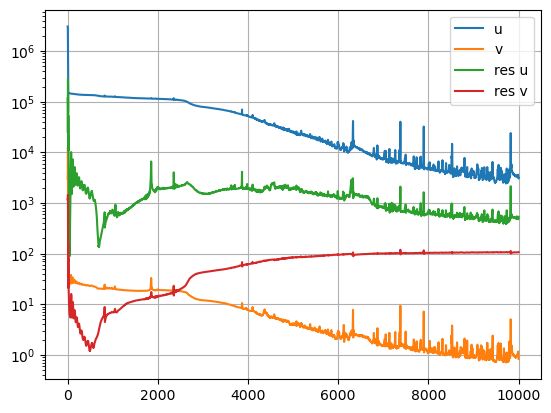

In [13]:
plt.plot(losses2[:, 0], label='u')
plt.plot(losses2[:, 1], label='v')
plt.plot(losses2[:, 2], label='res u')
plt.plot(losses2[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [14]:
pattern.t_star.shape

(12,)

In [15]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn, pattern.t_star[-1:].astype(np.float32))


In [16]:
def RMSE(arr1, arr2):
    return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.025173517
v:  0.01800694
u_xx:  0.18259168
v_xx:  0.15668501
u_yy:  0.17619745
v_yy:  0.13803154
u_t:  0.35185465
v_t:  0.5487088


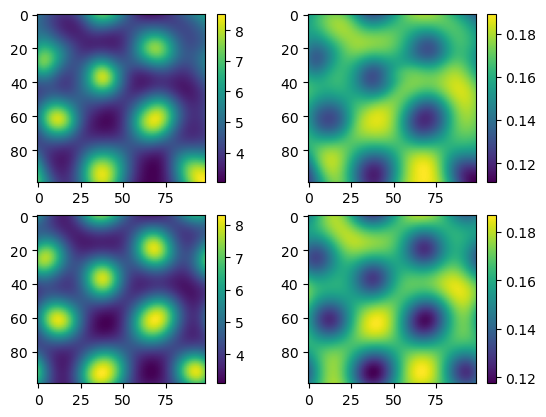

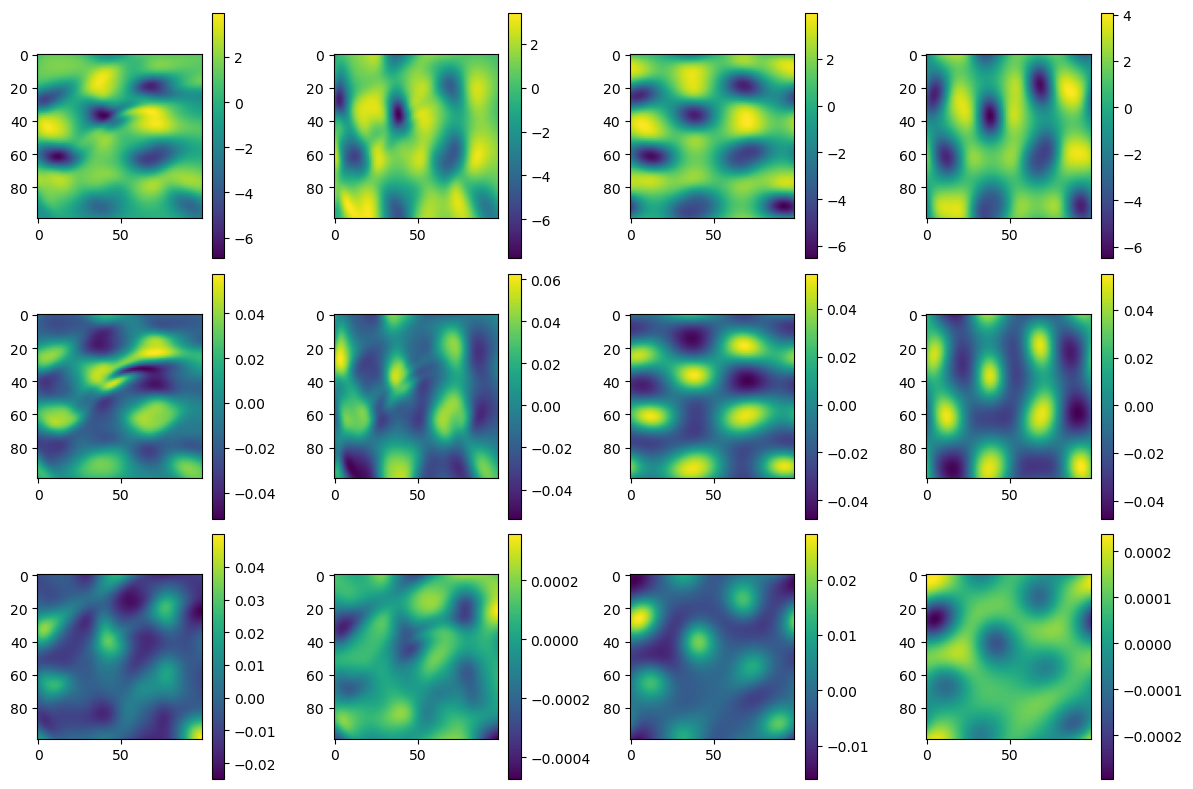

In [17]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(v)
plt.colorbar()
plt.subplot(223)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(343)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(347)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()

In [18]:
optimizer2=keras.optimizers.Adam(learning_rate=2e-4)
pinn2 = NN_Field(x_range, y_range, 
                depth=32, 
                dim_2d=(pattern.block_x, pattern.block_x), 
                layer_num = 6,
                dtype=tf.float32)
norm_l2 = L2()

init_per = 2.0
D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")#tf.Variable(pattern.params["D_u"]*init_per, pinn.dtype)
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")#tf.Variable(pattern.params["D_v"]*init_per, pinn.dtype)
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 0, 1e10,)

sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)

@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(pinn2.X)
        tape.watch(pinn2.Y)
        #tape.watch(t)
        trainables = pinn2.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(pinn2.X)
            tape2.watch(pinn2.Y)
            T = pinn2.make_inputs(elements[0])
            #tape2.watch(T)
            
            outputs = pinn2.net(T)            
            u = outputs[:, :, :, 0]
            v = outputs[:, :, :, 1]
            
            u_x = tape2.gradient(u, pinn2.X)
            u_y = tape2.gradient(u, pinn2.Y)
            #u_t = tape2.gradient(u, T)
            #u_t = tf.einsum("ijt -> tij", u_t)
            
            v_x = tape2.gradient(v, pinn2.X)
            v_y = tape2.gradient(v, pinn2.Y)
            #v_t = tape2.gradient(v, T)
            #v_t = tf.einsum("ijt -> tij", v_t)
            
        
        u_xx = tape.gradient(u_x, pinn2.X)
        #u_xy = tape.gradient(u_x, pinn.Y)
        #u_yx = tape.gradient(u_y, pinn.X)
        u_yy = tape.gradient(u_y, pinn2.Y)
        v_xx = tape.gradient(v_x, pinn2.X)
        v_yy = tape.gradient(v_y, pinn2.Y)
        #v_xy = tape.gradient(v_x, pinn.Y)
        #v_yx = tape.gradient(v_y, pinn.X)
        #print(u_xx)
        #partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
               
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u# - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v# - v_t
        
        #print(u.shape)
        #print(u_xx.shape)
        #u_xyyx_diff = u_xy - u_yx
        #v_xyyx_diff = v_xy - v_yx

        #diff = outputs - elements[1] 
        #print(elements[1].shape)
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)


        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        #l2_res_u_xyyx = tf.reduce_sum(u_xyyx_diff**2)
        #l2_res_v_xyyx = tf.reduce_sum(v_xyyx_diff**2)
        
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v #+ l2_res_u_xyyx + l2_res_v_xyyx
        
       
    grads = tape.gradient(l2, trainables + params_tf)
    optimizer2.apply_gradients(zip(grads, trainables + params_tf))
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)#, l2_res_u_xyyx, l2_res_v_xyyx)


In [19]:
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n")
    printer(#f"D_u: {D_u.numpy()}, D_v: {D_v.numpy()} \n"
            f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()} \n"
            f"sigma_u: {sigma_u.numpy()}, sigma_v: {sigma_v.numpy()} \n"
            f"kappa_u: {kappa_u.numpy()}, mu_u: {mu_u.numpy()} \n")
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}")
losses = tu.train(epochs=10000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 297551.34375 u: 258628.546875, v: 247.83819580078125,
 Res u: 38291.484375, Res v: 383.4659423828125 

rho_u: 2.0015857219696045, rho_v: 0.04866670072078705 
sigma_u: 1.9976011514663696, sigma_v: 0.19760112464427948 
kappa_u: 0.0, mu_u: 2.0022432804107666 

Time taken: 14.74s

Start of epoch 100
at epoch 100
 total loss: 16639.701171875 u: 15663.896484375, v: 43.4245491027832,
 Res u: 931.8681030273438, Res v: 0.5113911628723145 

rho_u: 2.0079901218414307, rho_v: 0.0413019098341465 
sigma_u: 1.992188811302185, sigma_v: 0.16437043249607086 
kappa_u: 0.01807396113872528, mu_u: 2.0065033435821533 

Time taken: 38.55s

Start of epoch 200
at epoch 200
 total loss: 15829.78125 u: 15214.40625, v: 64.94996643066406,
 Res u: 550.1964111328125, Res v: 0.22882595658302307 

rho_u: 2.005510091781616, rho_v: 0.040254976600408554 
sigma_u: 1.9953471422195435, sigma_v: 0.16042101383209229 
kappa_u: 0.02132776565849781, mu_u: 2.002944231033325 

Time taken: 3


Start of epoch 2400
at epoch 2400
 total loss: 10408.47265625 u: 10311.919921875, v: 3.882420063018799,
 Res u: 91.76588439941406, Res v: 0.9046343564987183 

rho_u: 2.039353609085083, rho_v: 0.01681550219655037 
sigma_u: 2.1077778339385986, sigma_v: 0.0610012523829937 
kappa_u: 0.006537140812724829, mu_u: 1.9226059913635254 

Time taken: 40.17s

Start of epoch 2500
at epoch 2500
 total loss: 9852.8095703125 u: 9749.3271484375, v: 3.3492136001586914,
 Res u: 99.20082092285156, Res v: 0.9316014051437378 

rho_u: 2.0406017303466797, rho_v: 0.01694640889763832 
sigma_u: 2.1154003143310547, sigma_v: 0.06110173091292381 
kappa_u: 0.006597764324396849, mu_u: 1.918696403503418 

Time taken: 38.97s

Start of epoch 2600
at epoch 2600
 total loss: 9264.751953125 u: 9165.908203125, v: 3.607863664627075,
 Res u: 94.375, Res v: 0.8610532283782959 

rho_u: 2.0411486625671387, rho_v: 0.01634068973362446 
sigma_u: 2.122422218322754, sigma_v: 0.058729566633701324 
kappa_u: 0.006836258340626955, mu_u: 


Start of epoch 4800
at epoch 4800
 total loss: 1654.90576171875 u: 1534.57421875, v: 1.1887277364730835,
 Res u: 118.47484588623047, Res v: 0.66798996925354 

rho_u: 2.0418076515197754, rho_v: 0.007787915412336588 
sigma_u: 2.3650715351104736, sigma_v: 0.026187648996710777 
kappa_u: 0.007926578633487225, mu_u: 1.8357282876968384 

Time taken: 39.37s

Start of epoch 4900
at epoch 4900
 total loss: 1521.8785400390625 u: 1408.21484375, v: 1.349569320678711,
 Res u: 111.67306518554688, Res v: 0.6410224437713623 

rho_u: 2.041050672531128, rho_v: 0.006944246124476194 
sigma_u: 2.368345260620117, sigma_v: 0.023492585867643356 
kappa_u: 0.008212696760892868, mu_u: 1.8345626592636108 

Time taken: 38.61s

Start of epoch 5000
at epoch 5000
 total loss: 1493.8472900390625 u: 1361.890869140625, v: 1.3217638731002808,
 Res u: 129.93118286132812, Res v: 0.7034638524055481 

rho_u: 2.0408389568328857, rho_v: 0.006908533163368702 
sigma_u: 2.3721730709075928, sigma_v: 0.023293541744351387 
kappa_u: 


Start of epoch 7100
at epoch 7100
 total loss: 731.1813354492188 u: 618.1797485351562, v: 1.682303547859192,
 Res u: 110.73916625976562, Res v: 0.5801613330841064 

rho_u: 2.0320985317230225, rho_v: 0.0021868327166885138 
sigma_u: 2.4004952907562256, sigma_v: 0.007296851370483637 
kappa_u: 0.009351379238069057, mu_u: 1.813841700553894 

Time taken: 39.58s

Start of epoch 7200
at epoch 7200
 total loss: 736.4655151367188 u: 676.2359619140625, v: 2.134345293045044,
 Res u: 57.49945068359375, Res v: 0.5957381725311279 

rho_u: 2.0311717987060547, rho_v: 0.0007199941319413483 
sigma_u: 2.4009647369384766, sigma_v: 0.0026675653643906116 
kappa_u: 0.009965199045836926, mu_u: 1.8130022287368774 

Time taken: 38.73s

Start of epoch 7300
at epoch 7300
 total loss: 546.3042602539062 u: 485.99932861328125, v: 2.050703763961792,
 Res u: 57.583980560302734, Res v: 0.6702620983123779 

rho_u: 2.031038284301758, rho_v: 0.0006673142779618502 
sigma_u: 2.4012155532836914, sigma_v: 0.002320221858099103


Start of epoch 9600
at epoch 9600
 total loss: 543.7030639648438 u: 473.6905822753906, v: 2.74509334564209,
 Res u: 66.28440856933594, Res v: 0.9829699397087097 

rho_u: 2.023963689804077, rho_v: 0.0 
sigma_u: 2.4058001041412354, sigma_v: 5.43224741704762e-05 
kappa_u: 0.010651551187038422, mu_u: 1.7934755086898804 

Time taken: 39.72s

Start of epoch 9700
at epoch 9700
 total loss: 448.6080627441406 u: 387.5584411621094, v: 2.372356653213501,
 Res u: 57.654808044433594, Res v: 1.0224571228027344 

rho_u: 2.023991823196411, rho_v: 0.0 
sigma_u: 2.405668258666992, sigma_v: 2.5775116228032857e-06 
kappa_u: 0.010312319733202457, mu_u: 1.7928111553192139 

Time taken: 40.03s

Start of epoch 9800
at epoch 9800
 total loss: 595.485107421875 u: 535.782958984375, v: 2.7056994438171387,
 Res u: 56.05451202392578, Res v: 0.9419601559638977 

rho_u: 2.0232062339782715, rho_v: 0.0 
sigma_u: 2.4035463333129883, sigma_v: 6.978514284128323e-05 
kappa_u: 0.010631059296429157, mu_u: 1.7926987409591675

In [32]:
losses_2 = tu.train(epochs=10000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 668.4844360351562 u: 607.992431640625, v: 2.494060516357422,
 Res u: 56.85400390625, Res v: 1.1439400911331177 

rho_u: 2.022462844848633, rho_v: 0.0 
sigma_u: 2.4025018215179443, sigma_v: 0.0 
kappa_u: 0.010757621377706528, mu_u: 1.7915377616882324 

Time taken: 0.53s

Start of epoch 100
at epoch 100
 total loss: 377.5882568359375 u: 327.3106994628906, v: 2.079298973083496,
 Res u: 47.359107971191406, Res v: 0.8391851186752319 

rho_u: 2.0228431224823, rho_v: 0.0 
sigma_u: 2.401210069656372, sigma_v: 5.194448749534786e-05 
kappa_u: 0.00996297039091587, mu_u: 1.7912964820861816 

Time taken: 39.80s

Start of epoch 200
at epoch 200
 total loss: 384.1651916503906 u: 336.6212463378906, v: 2.39663028717041,
 Res u: 44.098106384277344, Res v: 1.049185037612915 

rho_u: 2.0219156742095947, rho_v: 0.0 
sigma_u: 2.40008282661438, sigma_v: 0.0 
kappa_u: 0.010473760776221752, mu_u: 1.7908543348312378 

Time taken: 40.00s

Start of epoch 300
at epoch 300



Start of epoch 2400
at epoch 2400
 total loss: 235.2968292236328 u: 196.77377319335938, v: 1.3295037746429443,
 Res u: 36.68302917480469, Res v: 0.510523796081543 

rho_u: 2.0094833374023438, rho_v: 0.0057419962249696255 
sigma_u: 2.351123571395874, sigma_v: 0.019886260852217674 
kappa_u: 0.008098290301859379, mu_u: 1.8002862930297852 

Time taken: 39.18s

Start of epoch 2500
at epoch 2500
 total loss: 312.8276062011719 u: 272.52886962890625, v: 1.228608250617981,
 Res u: 38.504615783691406, Res v: 0.5655313730239868 

rho_u: 2.0091793537139893, rho_v: 0.006610343232750893 
sigma_u: 2.3499844074249268, sigma_v: 0.02186541073024273 
kappa_u: 0.00784230511635542, mu_u: 1.8004603385925293 

Time taken: 39.77s

Start of epoch 2600
at epoch 2600
 total loss: 241.84445190429688 u: 206.3424072265625, v: 1.2232561111450195,
 Res u: 33.75749206542969, Res v: 0.5213070511817932 

rho_u: 2.0085322856903076, rho_v: 0.006712275557219982 
sigma_u: 2.348379135131836, sigma_v: 0.02243540994822979 
ka


Start of epoch 4700
at epoch 4700
 total loss: 231.22198486328125 u: 204.29074096679688, v: 1.0558544397354126,
 Res u: 25.458784103393555, Res v: 0.4166068136692047 

rho_u: 1.9954057931900024, rho_v: 0.008529523387551308 
sigma_u: 2.329885721206665, sigma_v: 0.02890676073729992 
kappa_u: 0.00733162323012948, mu_u: 1.8055188655853271 

Time taken: 39.29s

Start of epoch 4800
at epoch 4800
 total loss: 194.28472900390625 u: 165.06515502929688, v: 1.0101399421691895,
 Res u: 27.788471221923828, Res v: 0.4209625720977783 

rho_u: 1.9949030876159668, rho_v: 0.008997756987810135 
sigma_u: 2.3292932510375977, sigma_v: 0.030680326744914055 
kappa_u: 0.0071477447636425495, mu_u: 1.8057386875152588 

Time taken: 39.10s

Start of epoch 4900
at epoch 4900
 total loss: 132.34454345703125 u: 105.1032485961914, v: 1.039731502532959,
 Res u: 25.77852439880371, Res v: 0.4230330288410187 

rho_u: 1.9942277669906616, rho_v: 0.008656363002955914 
sigma_u: 2.3287317752838135, sigma_v: 0.0296404603868722


Start of epoch 7000
at epoch 7000
 total loss: 134.77963256835938 u: 109.81288146972656, v: 0.9108319282531738,
 Res u: 23.62905502319336, Res v: 0.42686817049980164 

rho_u: 1.981835961341858, rho_v: 0.01001445297151804 
sigma_u: 2.319401979446411, sigma_v: 0.034788213670253754 
kappa_u: 0.0068177334032952785, mu_u: 1.8089542388916016 

Time taken: 39.77s

Start of epoch 7100
at epoch 7100
 total loss: 95.86343383789062 u: 74.64947509765625, v: 0.8994386196136475,
 Res u: 19.89349365234375, Res v: 0.42102548480033875 

rho_u: 1.9812722206115723, rho_v: 0.010190996341407299 
sigma_u: 2.3188748359680176, sigma_v: 0.03526446968317032 
kappa_u: 0.0067649479024112225, mu_u: 1.809147596359253 

Time taken: 39.89s

Start of epoch 7200
at epoch 7200
 total loss: 79.76575469970703 u: 56.11555480957031, v: 0.9048128724098206,
 Res u: 22.323078155517578, Res v: 0.4223117232322693 

rho_u: 1.9806994199752808, rho_v: 0.010179968550801277 
sigma_u: 2.318575382232666, sigma_v: 0.0353514738380909 
k


Start of epoch 9300
at epoch 9300
 total loss: 60.350154876708984 u: 43.059783935546875, v: 0.804402232170105,
 Res u: 16.030147552490234, Res v: 0.4558217525482178 

rho_u: 1.968937873840332, rho_v: 0.011263251304626465 
sigma_u: 2.316488027572632, sigma_v: 0.03909386694431305 
kappa_u: 0.006403280422091484, mu_u: 1.810845971107483 

Time taken: 40.65s

Start of epoch 9400
at epoch 9400
 total loss: 88.53719329833984 u: 68.55738830566406, v: 0.7808367013931274,
 Res u: 18.748985290527344, Res v: 0.4499788284301758 

rho_u: 1.9684085845947266, rho_v: 0.011453370563685894 
sigma_u: 2.3165664672851562, sigma_v: 0.03925113379955292 
kappa_u: 0.006363376975059509, mu_u: 1.8108853101730347 

Time taken: 40.68s

Start of epoch 9500
at epoch 9500
 total loss: 62.954647064208984 u: 45.0150146484375, v: 0.7670379877090454,
 Res u: 16.726974487304688, Res v: 0.4456217288970947 

rho_u: 1.9678950309753418, rho_v: 0.011558685451745987 
sigma_u: 2.316542387008667, sigma_v: 0.04006817191839218 
kap

In [38]:
losses_3 = tu.train(epochs=20000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 54.2353515625 u: 39.336585998535156, v: 0.75279700756073,
 Res u: 13.698412895202637, Res v: 0.4475557506084442 

rho_u: 1.9652210474014282, rho_v: 0.011744145303964615 
sigma_u: 2.3169591426849365, sigma_v: 0.040700461715459824 
kappa_u: 0.0062291803769767284, mu_u: 1.8111094236373901 

Time taken: 0.49s

Start of epoch 500
at epoch 500
 total loss: 52.865299224853516 u: 38.99931716918945, v: 0.7405064105987549,
 Res u: 12.680618286132812, Res v: 0.4448603391647339 

rho_u: 1.9625080823898315, rho_v: 0.011810715310275555 
sigma_u: 2.316962242126465, sigma_v: 0.04118053987622261 
kappa_u: 0.0061843316070735455, mu_u: 1.8114030361175537 

Time taken: 199.63s

Start of epoch 1000
at epoch 1000
 total loss: 140.5055694580078 u: 121.06622314453125, v: 0.7794684767723083,
 Res u: 18.205535888671875, Res v: 0.4543411135673523 

rho_u: 1.9598252773284912, rho_v: 0.011708676815032959 
sigma_u: 2.317049026489258, sigma_v: 0.0412302240729332 
kappa_u: 0.


Start of epoch 11500
at epoch 11500
 total loss: 36.428932189941406 u: 28.724977493286133, v: 0.2950168550014496,
 Res u: 6.99109411239624, Res v: 0.4178431034088135 

rho_u: 1.9033743143081665, rho_v: 0.01802578754723072 
sigma_u: 2.2969815731048584, sigma_v: 0.06547544151544571 
kappa_u: 0.004190561827272177, mu_u: 1.8255857229232788 

Time taken: 192.81s

Start of epoch 12000
at epoch 12000
 total loss: 50.68901443481445 u: 42.440757751464844, v: 0.27780213952064514,
 Res u: 7.530233860015869, Res v: 0.4402187466621399 

rho_u: 1.900871753692627, rho_v: 0.018316036090254784 
sigma_u: 2.2971079349517822, sigma_v: 0.06615084409713745 
kappa_u: 0.004122153855860233, mu_u: 1.8261147737503052 

Time taken: 200.96s

Start of epoch 12500
at epoch 12500
 total loss: 47.59483337402344 u: 42.21483612060547, v: 0.2631362974643707,
 Res u: 4.718501091003418, Res v: 0.3983578085899353 

rho_u: 1.8983641862869263, rho_v: 0.01854831539094448 
sigma_u: 2.2967512607574463, sigma_v: 0.06734684854745

In [45]:
losses_4 = tu.train(epochs=20000+1,
                  batch_size=1,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  print_interval=500,
                  loss_sample_interval = 1,
                  stop_threshold=1e-5,
                  print_callback = print_callback,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 18.097864151000977 u: 14.324031829833984, v: 0.17549702525138855,
 Res u: 3.1872925758361816, Res v: 0.41104406118392944 

rho_u: 1.8677871227264404, rho_v: 0.020381255075335503 
sigma_u: 2.3020358085632324, sigma_v: 0.07488740235567093 
kappa_u: 0.003414703533053398, mu_u: 1.8279879093170166 

Time taken: 0.50s

Start of epoch 500
at epoch 500
 total loss: 41.1507453918457 u: 34.964900970458984, v: 0.1655488759279251,
 Res u: 5.60177755355835, Res v: 0.4185173511505127 

rho_u: 1.8660235404968262, rho_v: 0.020564576610922813 
sigma_u: 2.3024609088897705, sigma_v: 0.0753527358174324 
kappa_u: 0.003366989316418767, mu_u: 1.8278199434280396 

Time taken: 197.76s

Start of epoch 1000
at epoch 1000
 total loss: 20.678674697875977 u: 16.71428680419922, v: 0.1793021410703659,
 Res u: 3.396892547607422, Res v: 0.3881925046443939 

rho_u: 1.8642743825912476, rho_v: 0.02035660110414028 
sigma_u: 2.3029870986938477, sigma_v: 0.07548974454402924 
kappa_u:


Start of epoch 11500
at epoch 11500
 total loss: 42.89472961425781 u: 38.803199768066406, v: 0.1476333737373352,
 Res u: 3.5981032848358154, Res v: 0.3457953929901123 

rho_u: 1.8331183195114136, rho_v: 0.021217573434114456 
sigma_u: 2.3078792095184326, sigma_v: 0.07909836620092392 
kappa_u: 0.003004110185429454, mu_u: 1.818333387374878 

Time taken: 198.41s

Start of epoch 12000
at epoch 12000
 total loss: 8.635106086730957 u: 5.914383411407471, v: 0.14330029487609863,
 Res u: 2.233546257019043, Res v: 0.3438756465911865 

rho_u: 1.8317210674285889, rho_v: 0.021174199879169464 
sigma_u: 2.3079915046691895, sigma_v: 0.07886824011802673 
kappa_u: 0.003009967738762498, mu_u: 1.8178110122680664 

Time taken: 198.07s

Start of epoch 12500
at epoch 12500
 total loss: 7.356373310089111 u: 4.786953449249268, v: 0.14098674058914185,
 Res u: 2.0901246070861816, Res v: 0.33830851316452026 

rho_u: 1.830337643623352, rho_v: 0.021294113248586655 
sigma_u: 2.307952880859375, sigma_v: 0.07935091853

In [ ]:
'rho_u': 1.0  , 'rho_v': 0.025,
'sigma_u': 1.0, 'sigma_v': 0.1
'kappa_u': 0.0, 'mu_u': 1.0,

In [97]:
def Euclidian_L(vec1, vec2):
    def L(v):
        return np.sqrt(np.sum(v**2))
    v2 = vec2.copy()
    v2[v2==0] = 1
    return L((vec1-vec2)/v2)

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

print(f"U params. estimates: {Euclidian_L(u_vec, u_vec_ac)}")
print(f"V params. estimates: {Euclidian_L(v_vec, v_vec_ac)}")

U params. estimates: 1.7386954128330572
V params. estimates: 0.2342907432374033


In [39]:
pattern.params

{'D_u': 0.1,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 1.0,
 'mu_u': 1.0,
 'sigma_u': 1.0,
 'rho_v': 0.025,
 'sigma_v': 0.1}

In [47]:
losses2 = np.array(losses + losses_2 +losses_3 +losses_4)
element_nums_by = 12#len(losses)//2
losses2 =np.concatenate([sum_per(losses2[:, 0], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 1], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 2], element_nums_by)[:, np.newaxis],
                         sum_per(losses2[:, 3], element_nums_by)[:, np.newaxis],                        
                        ], axis=1)

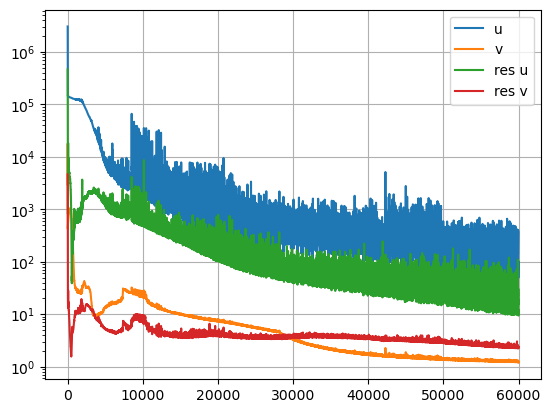

In [48]:
plt.plot(losses2[:, 0], label='u')
plt.plot(losses2[:, 1], label='v')
plt.plot(losses2[:, 2], label='res u')
plt.plot(losses2[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [49]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn2, pattern.t_star[-1:].astype(np.float32))

In [53]:
def RMSE(arr1, arr2):
    #return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
    return np.sqrt(np.mean(((arr1-arr2)/(arr2+1e-20))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.0050259577
v:  0.024645321
u_xx:  50.820587
v_xx:  24.161999
u_yy:  31.543333
v_yy:  4.6418004
u_t:  12.04193
v_t:  11.55047


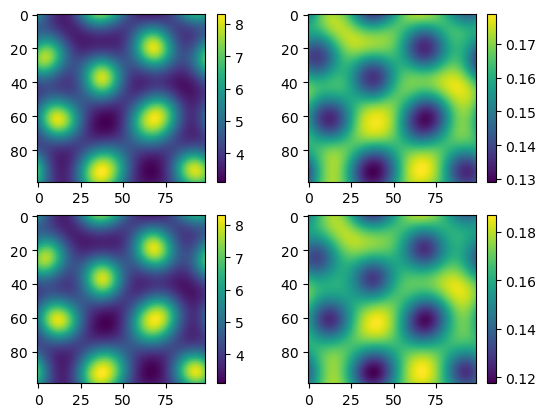

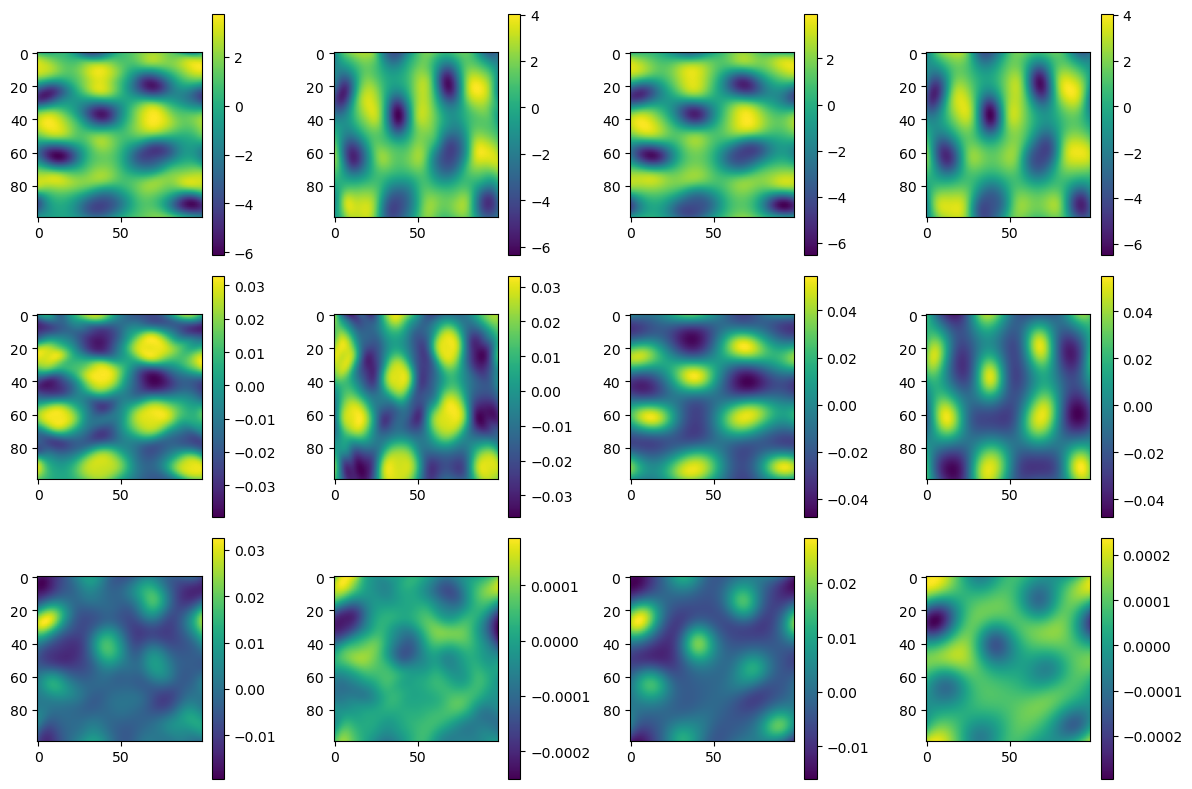

In [51]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(v)
plt.colorbar()
plt.subplot(223)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(343)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(347)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()

In [96]:
from scipy.optimize import lsq_linear
from scipy import linalg

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

params2 = np.concatenate([u_vec[:-1], v_vec[:-1]])
params3 = np.concatenate([u_vec_ac[:-1], v_vec_ac[:-1]])

u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()
n2 = u_sol.shape[0]
kappa_sol = kappa_u.numpy()#pde_resKM.kappa_u.get_value(0).numpy()[0]

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)


uxxyy_sol = D_u.numpy()*(u_xx.numpy() + u_yy.numpy()).flatten()
vxxyy_sol = D_v.numpy()*(v_xx.numpy() + v_yy.numpy()).flatten()

A_sol =  np.vstack((np.c_[f_sol,  u_sol,  [1]*n2, [0]*n2, [0]*n2],
                    np.c_[[0]*n2, [0]*n2, [0]*n2,-f_sol,  [1]*n2]))


u_dt_sol = (u_t.numpy()).flatten()
v_dt_sol = (v_t.numpy()).flatten()

b_sol =  np.r_[(u_dt_sol-uxxyy_sol, v_dt_sol-vxxyy_sol)]

In [94]:
np.sqrt(np.mean(((np.dot(A_sol, params2)-b_sol))**2))

13.174233026630345

In [95]:
np.sqrt(np.mean(((np.dot(A_sol, params3)-b_sol))**2))

7.066173436734661